[View in Colaboratory](https://colab.research.google.com/github/oleges1/practise/blob/master/face_points/face_points.ipynb)

## Prepare gdrive!

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [1]:
!ls drive/

02042016		   main_model.h5
1			   Oleg
best.h5			   papa_black4096.h5
birds			   papa_white1024.h5
birds_model.hdf5	   papa_white4096 (888e0004).h5
black (1c554a75).renju	   papa_white4096.h5
black.renju		   Renju
Classroom		   second.h5
cloud			   VARIANT_4.rtf.odt
cnn_labs (3994be72).ipynb  white4096 (1b9f003e).h5
cnn_labs (99aa7e01).ipynb  white4096.h5
cnn_labs.ipynb		   white.renju
Colab Notebooks		   Материалы
Copy			   Материалы старое
face_points		   Практика
fasttext		   Табличка
main_model8.h5		   Файлы и документы


## Load data

In [0]:
path_to_raw = 'drive/face_points/images'

In [0]:
path = 'drive/face_points'

In [0]:
path_to_gt = 'drive/face_points/gt.csv'

In [0]:
import pandas as pd

In [6]:
shapes = pd.read_csv('drive/face_points/img_shapes.csv')
shapes.sort_values(by = 'n_rows')[:5]

,img_filename,n_rows,n_cols
4330,04330.jpg,34,34
5964,05964.jpg,34,34
5808,05808.jpg,35,35
739,00739.jpg,35,35
2766,02766.jpg,36,36


In [7]:
shapes[shapes['n_rows'] != shapes['n_cols']][:5]

,img_filename,n_rows,n_cols
19,00019.jpg,686,682
20,00020.jpg,314,358
36,00036.jpg,352,290
46,00046.jpg,298,311
61,00061.jpg,569,602


In [8]:
shapes = pd.read_csv('drive/face_points/img_shapes.csv')
shapes.sort_values(by = 'n_rows')[:5]

,img_filename,n_rows,n_cols
4330,04330.jpg,34,34
5964,05964.jpg,34,34
5808,05808.jpg,35,35
739,00739.jpg,35,35
2766,02766.jpg,36,36


In [9]:
len(shapes[shapes['n_rows'] < 100])

1514

In [10]:
labels = pd.read_csv(path_to_gt)
labels.head(5)

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


In [11]:
!pip3 install tqdm

In [12]:
import os
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, load_img
from random import randint

from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Activation, GlobalMaxPooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, BatchNormalization
from keras import backend as K

from keras.callbacks import LambdaCallback, ProgbarLogger

from keras.optimizers import Adam

from tqdm import tqdm_notebook, tqdm

#from run_tests import read_csv, save_csv

from skimage.transform import resize
from random import randint

Using TensorFlow backend.


In [0]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

In [0]:
# rewrite
# think about data flipping or rotare, even with the labels

class data_storage():
  def __init__(self, path, path_to_gt, path_to_raw, shapes_path = 'drive/face_points/img_shapes.csv', size = 100):
      self.path = path
      self.path_to_gt = path_to_gt
      self.labels = pd.read_csv(path_to_gt)
      self.shapes = pd.read_csv(shapes_path)
      self.size = size
      
      path_to_datas = [path + '/x.npy', path + '/y.npy']
      try:
          self.x = np.load(path_to_datas[0])
          self.y = np.load(path_to_datas[1])
      except:
          self.x = np.zeros((len(self.labels), size, size, 3), dtype = np.float32)
          self.y = np.zeros((len(self.labels), 28), dtype = np.float32)
          for i, data in enumerate(tqdm(self.labels['filename'])):
              image = np.array(load_img(path_to_raw + '/' +  data, target_size = (size, size)), dtype = np.float32)
              image -= np.mean(image, keepdims=True)
              image /= (np.std(image, keepdims=True) + 0.00001)
              self.x[i] = image
              self.y[i] = np.array(self.labels.iloc[i][1:])
              for j in range(len(self.y[i])):
                if j % 2 == 0:
                  self.y[i][j] = self.y[i][j] * size / self.shapes.iloc[i]['n_rows']
                else:
                  self.y[i][j] = self.y[i][j] * size / self.shapes.iloc[i]['n_cols']
          np.save(path_to_datas[0], self.x)
          np.save(path_to_datas[1], self.y)
          
   
  # better to use keras flow
  def generator(self, fast_run = False):
      x_batch = np.zeros((batch_size, self.size, self.size, 3), dtype = np.float32)
      y_batch = np.zeros((batch_size, 50))
      full_indx = np.arange(len(self.labels))
      full_indx = np.random.shuffle(full_indx)
      begin_batch = 0
      while True:
        if fast_run:
            filename_idxs = np.random.choice(len(self.labels), batch_size)
        else:
            if begin_batch + batch_size < len(dataset):
                filename_idxs = full_indx[begin_batch : begin_batch + batch_size]
                begin_batch += batch_size
            else:
                filename_idxs = full_indx[begin_batch : len(dataset)]
                begin_batch = (begin_batch + batch_size) % len(dataset)
                filename_idxs += full_indx[0 : begin_batch]
        filenames = [list(dataset.keys())[filename_idx] for filename_idx in filename_idxs]
        
        for i in range(batch_size):
            image = self.x[filename_idxs[i]]
            seed = randint(0, 3)
            image = rotare(image, seed)
            
            x_batch[i] = image
            y_batch[i] = 1
        yield x_batch, y_batch

In [0]:
datas = data_storage(path, path_to_gt, path_to_raw)

In [0]:
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.layers import BatchNormalization, Convolution2D, Input, merge, LeakyReLU, MaxPooling2D
from keras.layers.core import Activation, Layer
from keras.optimizers import SGD, Adam

In [17]:
def conv_block_3(feat_maps_out, prev):
    prev = BatchNormalization()(prev)
    prev = Conv2D(feat_maps_out, (3, 3), padding='same')(prev) 
    prev = LeakyReLU()(prev)
    prev = BatchNormalization()(prev)
    prev = Conv2D(feat_maps_out, (2, 2), padding='same')(prev) 
    prev = LeakyReLU()(prev)
    return prev

def skip_block(feat_maps_in, feat_maps_out, prev):
    if feat_maps_in != feat_maps_out:
        prev = Conv2D(feat_maps_out, (1, 1), padding='same')(prev)
    return prev 

def Residual_3(feat_maps_in, feat_maps_out, prev_layer):
    skip = skip_block(feat_maps_in, feat_maps_out, prev_layer)
    conv = conv_block_3(feat_maps_out, prev_layer)
    return merge([skip, conv], mode='sum')

img_rows = 100 
img_cols = 100 

inp = Input((img_rows, img_cols, 3))
cnv1 = Conv2D(32, (3, 3), padding='same')(inp)
cnv1 = LeakyReLU()(cnv1)
cnv1 = BatchNormalization()(cnv1)
r1 = Residual_3(32, 32, cnv1)
r1 = Dropout(0.1)(r1)
r1 = Residual_3(32, 32, r1)
r1 = Dropout(0.1)(r1)
r1 = Residual_3(32, 32, r1)
r1 = Dropout(0.1)(r1)
pool1 = MaxPooling2D(pool_size = (2, 2))(r1)
r2 = Residual_3(32, 32, pool1)
r2 = Dropout(0.1)(r2)
r2 = Residual_3(32, 32, r2)
r2 = Dropout(0.1)(r2)
r2 = Residual_3(32, 32, r2)
r2 = Dropout(0.1)(r2)
pool2 = MaxPooling2D(pool_size = (2, 2))(r2)
r3 = Residual_3(32, 32, pool2)
r3 = Dropout(0.1)(r3)
r3 = Residual_3(32, 32, r3)
r3 = Dropout(0.1)(r3)
r3 = Residual_3(32, 32, r3)
r3 = Dropout(0.1)(r3)
pool3 = MaxPooling2D(pool_size = (2, 2))(r3)
r4 = Residual_3(32, 32, pool3)
r4 = Dropout(0.1)(r4)
r4 = Residual_3(32, 32, r4)
r4 = Dropout(0.1)(r4)
r4 = Residual_3(32, 32, r4)
r4 = Dropout(0.1)(r4)
pool4 = MaxPooling2D(pool_size = (2, 2))(r4)
r5 = Residual_3(32, 32, pool4)
r5 = Dropout(0.1)(r5)
r5 = Residual_3(32, 32, r5)
r5 = Dropout(0.1)(r5)
r5 = Residual_3(32, 32, r5)
r5 = Dropout(0.1)(r5)
pool5 = MaxPooling2D(pool_size = (2, 2))(r5)
flt = Flatten()(pool5)
dense1 = Dense(100, activation = 'relu')(flt)
dense1 = Dropout(0.25)(dense1)
#dense1 = BatchNormalization()(dense1)
dense2 = Dense(28, activation = 'linear')(dense1)
#out = Activation('linear')(dense2)
model = Model(input=inp, output=dense2)
#sgd = optimizers.SGD(lr=0.01,momentum = 0.9,nesterov=True)
model.compile(loss="mean_squared_error",optimizer='adam')
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 100, 100, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 32) 128         leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (100, 100, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(256))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(28))
    sgd = Adam(lr =0.0005, decay = 1e-8)
    model.compile(loss="mean_squared_error",optimizer=sgd)
    return(model)

In [0]:
model = SimpleCNN(withDropout = False)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datas.x, datas.y, test_size=0.2)

In [0]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    img = X.reshape(100,100,3)
    image = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
    axs.imshow(image,cmap="gray")
    axs.scatter(y[0::2],y[1::2])

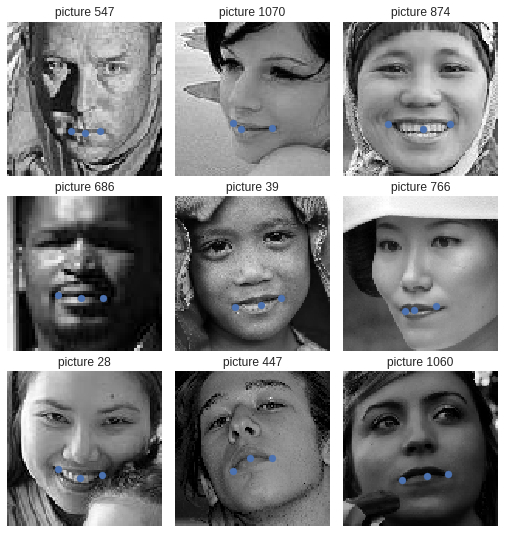

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                     left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])
    plot_sample(X_test[ipic],y_test[ipic][22: 28],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()



In [0]:
class DataModifier(object):
    def fit(self,X_,y_):
        return(NotImplementedError)
    
class FlipPic(DataModifier):
    def __init__(self,flip_indices=None):
        if flip_indices is None:
            flip_indices = [
                (0, 6), (1, 7),
                (2, 4), (3, 5), (12, 14), (13, 15),
                (8, 18), (9, 19), (10, 16), (11, 17),
                (22, 26), (23, 27)
                ]
        
        self.flip_indices = flip_indices
        
    def fit(self,X_batch,y_batch):

        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size//2, replace=False)

        X_batch[indices] = X_batch[indices, :, ::-1,:]
        y_batch[indices, ::2] = y_batch[indices, ::2] * -1 + 100

        # flip left eye to right eye, left mouth to right mouth and so on .. 
        for a, b in self.flip_indices:
            y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch

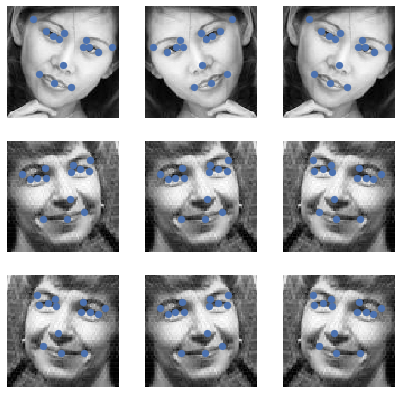

In [24]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
modifier = FlipPic()

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:2],y_train[:2]):
    X_batch, y_batch = modifier.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
modifier = FlipPic()

In [0]:
def fit(model,modifier,train,validation,
        batch_size=32,epochs=2000,print_every=10,patience=np.Inf):
    '''
    model :        keras model object
    Modifier:      DataModifier() object
    train:         tuple containing two numpy arrays (X_train,y_train)
    validation:    tuple containing two numpy arrays (X_val,y_val)
    patience:      The back propagation algorithm will stop if the val_loss does not decrease 
                   after  epochs
    '''
    
    ## manually write fit method
    X_train,y_train = train
    X_val, y_val    = validation
    
    generator = ImageDataGenerator()
    
    history = {"loss":[],"val_loss":[]}
    for e in range(epochs):
        if e % print_every == 0:
            print('Epoch {:4}:'.format(e)), 
        ## -------- ##
        ## training
        ## -------- ##
        batches = 0
        loss_epoch = []
        for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size):
            X_batch, y_batch = modifier.fit(X_batch, y_batch)
            hist = model.fit(X_batch, y_batch,verbose=False,epochs=1)
            loss_epoch.extend(hist.history["loss"])
            batches += 1
            if batches >= len(X_train) / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break   
        loss = np.mean(loss_epoch)
        history["loss"].append(loss)
        ## --------- ##
        ## validation
        ## --------- ##
        y_pred = model.predict(X_val)
        val_loss = np.mean((y_pred - y_val)**2)
        history["val_loss"].append(val_loss)
        if e % print_every == 0:
            print("loss - {:6.5f}, val_loss - {:6.5f}".format(loss,val_loss))
        min_val_loss = np.min(history["val_loss"])
        ## Early stopping
        if patience is not np.Inf:
            if np.all(min_val_loss < np.array(history["val_loss"])[-patience:]):
                break
    return(history)

In [80]:
fit(model,modifier,
           train=(X_train,y_train),
           validation=(X_test,y_test),
           batch_size=32, epochs=22, print_every=1
           )

Epoch    0:
loss - 162.14810, val_loss - 35.48162
Epoch    1:
loss - 31.83674, val_loss - 25.62566
Epoch    2:
loss - 24.05691, val_loss - 20.37307
Epoch    3:
loss - 21.83670, val_loss - 20.54052
Epoch    4:
loss - 19.81016, val_loss - 17.15549
Epoch    5:
loss - 19.92323, val_loss - 17.83185
Epoch    6:
loss - 17.08256, val_loss - 17.13621
Epoch    7:
loss - 16.55310, val_loss - 18.25899
Epoch    8:
loss - 16.12993, val_loss - 15.58002
Epoch    9:
loss - 14.84099, val_loss - 14.84898
Epoch   10:
loss - 13.97919, val_loss - 16.49606
Epoch   11:
loss - 13.20310, val_loss - 13.63456
Epoch   12:
loss - 12.36981, val_loss - 13.34840
Epoch   13:
loss - 12.62810, val_loss - 13.56053
Epoch   14:
loss - 11.06072, val_loss - 12.81806
Epoch   15:
loss - 10.38380, val_loss - 12.50963
Epoch   16:
loss - 10.26773, val_loss - 16.28401
Epoch   17:
loss - 10.21407, val_loss - 11.59295
Epoch   18:
loss - 9.31198, val_loss - 11.33966
Epoch   19:
loss - 8.51080, val_loss - 11.04857
Epoch   20:
loss - 8.

{'loss': [162.14810222625732,
  31.83674487431844,
  24.05690970102946,
  21.836699250539144,
  19.81015514373779,
  19.923234071731567,
  17.08256044069926,
  16.553103399276733,
  16.12992847442627,
  14.840990673700968,
  13.979185117085775,
  13.20310344060262,
  12.369814745585124,
  12.628102696736654,
  11.060722500483195,
  10.383804960250854,
  10.26772741317749,
  10.214072780609131,
  9.311981026331583,
  8.51080086072286,
  8.659519481658936,
  7.891183331807454],
 'val_loss': [35.481617,
  25.62566,
  20.373068,
  20.540524,
  17.155493,
  17.831852,
  17.13621,
  18.258991,
  15.580022,
  14.848982,
  16.496058,
  13.634557,
  13.348403,
  13.560527,
  12.818057,
  12.509632,
  16.284012,
  11.592949,
  11.33966,
  11.048568,
  10.493799,
  10.463861]}

In [81]:
fit(model,modifier,
           train=(X_train,y_train),
           validation=(X_test,y_test),
           batch_size=64, epochs=12, print_every=1
           )

Epoch    0:
loss - 7.62060, val_loss - 11.42715
Epoch    1:
loss - 7.58249, val_loss - 10.06041
Epoch    2:
loss - 7.45634, val_loss - 10.05653
Epoch    3:
loss - 6.86093, val_loss - 10.38771
Epoch    4:
loss - 6.84506, val_loss - 10.07886
Epoch    5:
loss - 6.53217, val_loss - 10.40886
Epoch    6:
loss - 6.42400, val_loss - 10.15167
Epoch    7:
loss - 6.14478, val_loss - 9.70896
Epoch    8:
loss - 6.19624, val_loss - 9.38789
Epoch    9:
loss - 5.94556, val_loss - 9.80722
Epoch   10:
loss - 6.06911, val_loss - 9.61046
Epoch   11:
loss - 5.92232, val_loss - 10.05199


{'loss': [7.620604225794474,
  7.5824928538004555,
  7.456342069307963,
  6.860925480524699,
  6.845056864420573,
  6.53217204729716,
  6.424001453717549,
  6.144784145355224,
  6.196240512530009,
  5.945558656056722,
  6.06911408106486,
  5.922316678365072],
 'val_loss': [11.42715,
  10.060406,
  10.056533,
  10.387714,
  10.078863,
  10.408861,
  10.151666,
  9.708964,
  9.387889,
  9.8072195,
  9.61046,
  10.051994]}

In [82]:
fit(model,modifier,
           train=(X_train,y_train),
           validation=(X_test,y_test),
           batch_size=128, epochs=8, print_every=1
           )

Epoch    0:
loss - 5.83105, val_loss - 9.39301
Epoch    1:
loss - 5.43974, val_loss - 10.24211
Epoch    2:
loss - 5.41306, val_loss - 9.23281
Epoch    3:
loss - 5.64947, val_loss - 9.40931
Epoch    4:
loss - 5.24583, val_loss - 9.31166
Epoch    5:
loss - 5.10631, val_loss - 9.98612
Epoch    6:
loss - 4.85007, val_loss - 9.35130
Epoch    7:
loss - 4.65068, val_loss - 9.27247


{'loss': [5.831052110383385,
  5.439735318485059,
  5.4130583421180125,
  5.649468977200358,
  5.245827704668045,
  5.106312925878324,
  4.850068090777648,
  4.6506768637581875],
 'val_loss': [9.393015,
  10.24211,
  9.232807,
  9.409313,
  9.311655,
  9.98612,
  9.351299,
  9.272473]}

In [83]:
fit(model,modifier,
           train=(X_train,y_train),
           validation=(X_test,y_test),
           batch_size=256, epochs=8, print_every=1
           )

Epoch    0:
loss - 4.69048, val_loss - 10.07024
Epoch    1:
loss - 4.80073, val_loss - 9.30556
Epoch    2:
loss - 4.46909, val_loss - 10.53262
Epoch    3:
loss - 4.57553, val_loss - 9.60750
Epoch    4:
loss - 4.36552, val_loss - 9.54225
Epoch    5:
loss - 4.34176, val_loss - 10.12931
Epoch    6:
loss - 4.32966, val_loss - 9.61761
Epoch    7:
loss - 4.08394, val_loss - 9.51696


{'loss': [4.690481734903235,
  4.800731800104442,
  4.469091730159626,
  4.575526313300719,
  4.365523318972504,
  4.3417566873525315,
  4.3296643924294855,
  4.083940808710299],
 'val_loss': [10.070241,
  9.305562,
  10.532621,
  9.607497,
  9.542247,
  10.129311,
  9.617612,
  9.516963]}

In [84]:
fit(model,modifier,
           train=(X_train,y_train),
           validation=(X_test,y_test),
           batch_size=1024, epochs=8, print_every=1
           )

Epoch    0:
loss - 4.19547, val_loss - 9.02198
Epoch    1:
loss - 3.76821, val_loss - 9.15283
Epoch    2:
loss - 3.93019, val_loss - 8.91115
Epoch    3:
loss - 3.65431, val_loss - 9.25941
Epoch    4:
loss - 3.59997, val_loss - 9.01050
Epoch    5:
loss - 3.53629, val_loss - 9.17939
Epoch    6:
loss - 3.57175, val_loss - 9.28403
Epoch    7:
loss - 3.54123, val_loss - 9.22688


{'loss': [4.195471685853872,
  3.7682092264294624,
  3.930190682546659,
  3.6543100790543988,
  3.5999699015508995,
  3.536285342817957,
  3.571753938631578,
  3.541229603371837],
 'val_loss': [9.021976,
  9.152834,
  8.911153,
  9.259406,
  9.010499,
  9.179391,
  9.284029,
  9.226883]}

In [122]:
model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4480/4800 [===========================>..] - ETA: 0s - loss: 8.0141

KeyboardInterrupt: ignored

In [164]:
model.fit(X_train, y_train, batch_size = 64, epochs = 3, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/3
4800/4800 [==============================] - 9s 2ms/step - loss: 17.0773 - val_loss: 14.6224
Epoch 2/3
4800/4800 [==============================] - 9s 2ms/step - loss: 16.5341 - val_loss: 16.1788
Epoch 3/3
4800/4800 [==============================] - 9s 2ms/step - loss: 14.9138 - val_loss: 13.4813


In [165]:
model.fit(X_train, y_train, batch_size = 128, epochs = 3, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/3
4800/4800 [==============================] - 8s 2ms/step - loss: 13.1669 - val_loss: 12.0118
Epoch 2/3
4800/4800 [==============================] - 8s 2ms/step - loss: 12.4109 - val_loss: 11.7881
Epoch 3/3
4800/4800 [==============================] - 8s 2ms/step - loss: 12.0397 - val_loss: 11.2060


In [166]:
model.fit(X_train, y_train, batch_size = 256, epochs = 3, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/3
4800/4800 [==============================] - 7s 2ms/step - loss: 10.5553 - val_loss: 10.9514
Epoch 2/3
4800/4800 [==============================] - 7s 2ms/step - loss: 9.8221 - val_loss: 12.1895
Epoch 3/3
4800/4800 [==============================] - 7s 2ms/step - loss: 10.0976 - val_loss: 11.0008


In [168]:
model.fit(X_train, y_train, batch_size = 512, epochs = 3, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/3
4800/4800 [==============================] - 7s 2ms/step - loss: 9.3306 - val_loss: 11.5262
Epoch 2/3
4800/4800 [==============================] - 7s 1ms/step - loss: 9.0933 - val_loss: 12.4029
Epoch 3/3
4800/4800 [==============================] - 7s 1ms/step - loss: 8.6935 - val_loss: 10.4320


In [169]:
model.fit(X_train, y_train, batch_size = 1024, epochs = 3, validation_data = (X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/3
4800/4800 [==============================] - 7s 1ms/step - loss: 7.8467 - val_loss: 10.1416
Epoch 2/3
4800/4800 [==============================] - 7s 1ms/step - loss: 7.8729 - val_loss: 9.9897
Epoch 3/3
4800/4800 [==============================] - 7s 1ms/step - loss: 7.6029 - val_loss: 10.4670


In [0]:
model.save(path + '/facepoints_model_validated_8.8.hdf5')

In [0]:
model = SimpleCNN(withDropout = False)
X, Y = datas.x, datas.y

In [177]:
model.fit(X, Y, batch_size = 32, epochs = 5)

Epoch 1/5
6000/6000 [==============================] - 17s 3ms/step - loss: 114.3692
Epoch 2/5
6000/6000 [==============================] - 13s 2ms/step - loss: 28.6905
Epoch 3/5
6000/6000 [==============================] - 13s 2ms/step - loss: 22.1720
Epoch 4/5
6000/6000 [==============================] - 13s 2ms/step - loss: 19.9597
Epoch 5/5
6000/6000 [==============================] - 13s 2ms/step - loss: 17.6702


In [178]:
model.fit(X, Y, batch_size = 64, epochs = 3)

Epoch 1/3
6000/6000 [==============================] - 11s 2ms/step - loss: 15.2058
Epoch 2/3
6000/6000 [==============================] - 10s 2ms/step - loss: 14.8023
Epoch 3/3
6000/6000 [==============================] - 10s 2ms/step - loss: 13.8894


In [179]:
model.fit(X, Y, batch_size = 128, epochs = 3)

Epoch 1/3
6000/6000 [==============================] - 10s 2ms/step - loss: 12.5291
Epoch 2/3
6000/6000 [==============================] - 9s 2ms/step - loss: 11.7609
Epoch 3/3
6000/6000 [==============================] - 9s 2ms/step - loss: 11.3836


In [180]:
model.fit(X, Y, batch_size = 256, epochs = 3)

Epoch 1/3
6000/6000 [==============================] - 8s 1ms/step - loss: 10.8568
Epoch 2/3
6000/6000 [==============================] - 8s 1ms/step - loss: 10.2374
Epoch 3/3
6000/6000 [==============================] - 8s 1ms/step - loss: 9.9620


In [181]:
model.fit(X, Y, batch_size = 512, epochs = 3)

Epoch 1/3
6000/6000 [==============================] - 10s 2ms/step - loss: 9.6057
Epoch 2/3
6000/6000 [==============================] - 8s 1ms/step - loss: 9.2012
Epoch 3/3
6000/6000 [==============================] - 8s 1ms/step - loss: 9.2087


In [182]:
model.fit(X, Y, batch_size = 1024, epochs = 3)

Epoch 1/3
6000/6000 [==============================] - 12s 2ms/step - loss: 9.3721
Epoch 2/3
6000/6000 [==============================] - 8s 1ms/step - loss: 8.6773
Epoch 3/3
6000/6000 [==============================] - 8s 1ms/step - loss: 8.5674


In [0]:
model.save(path + '/facepoints_model.hdf5')